# **MODERN COMPUTER VISION** #
##### BY RAJEEV RATAN

<h2 style="margin-bottom:0;">🚀 Colourize Black and White Photos using a Caffee Model in OpenCV</h2>

<h5 style="margin-top:5px;">In this lesson we'll learn how to use pre-trained Models to automatically Colourize a Black and White(grayscale) photo.</h5>

In [2]:
# Our Setup, Import Libraries and Create our Imshow Function
import numpy as np
import cv2
import time
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

# Define our imshow function
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Download and unzip our images
!gdown --id 1QWPRnL02rOgm6xZmcmfyWVuVubKeYry4
!unzip -qq colorize.zip

/home/robin/Self-learning/Tutorialspoint_Artificial_Intelligence_and_Machine_Learning_Certification_2026/Module_4_Modern_Computer_Vision/OpenCV/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1QWPRnL02rOgm6xZmcmfyWVuVubKeYry4
From (redirected): https://drive.google.com/uc?id=1QWPRnL02rOgm6xZmcmfyWVuVubKeYry4&confirm=t&uuid=50ebb134-3dff-4a74-a12c-246e079beb71
To: /home/robin/Self-learning/Tutorialspoint_Artificial_Intelligence_and_Machine_Learning_Certification_2026/Module_4_Modern_Computer_Vision/OpenCV/8.OpenCV_Projects/colorize.zip
100%|████████████████████████████████████████| 120M/120M [00:14<00:00, 8.42MB/s]


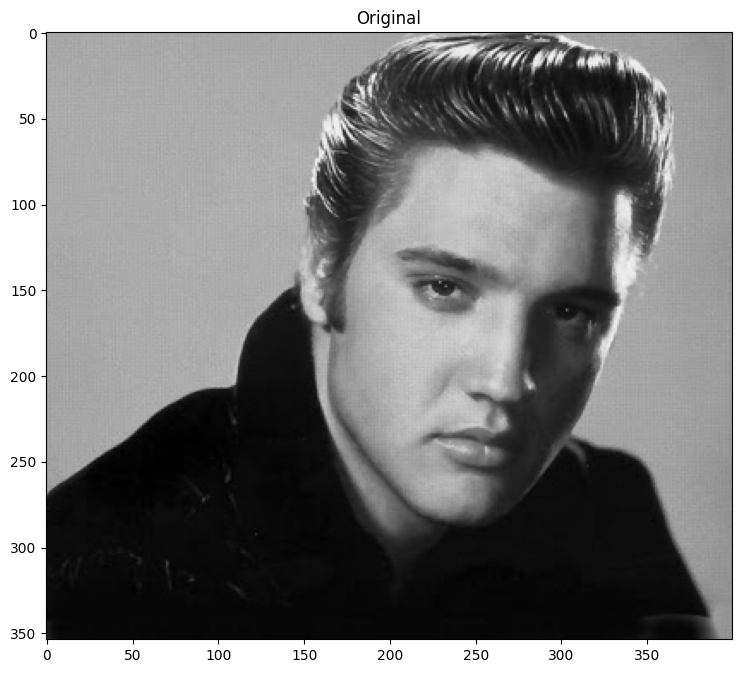

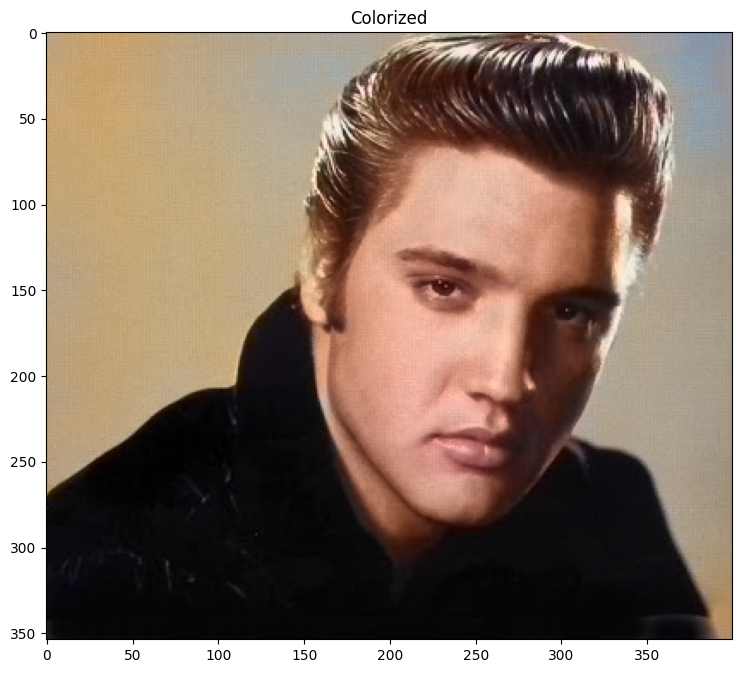

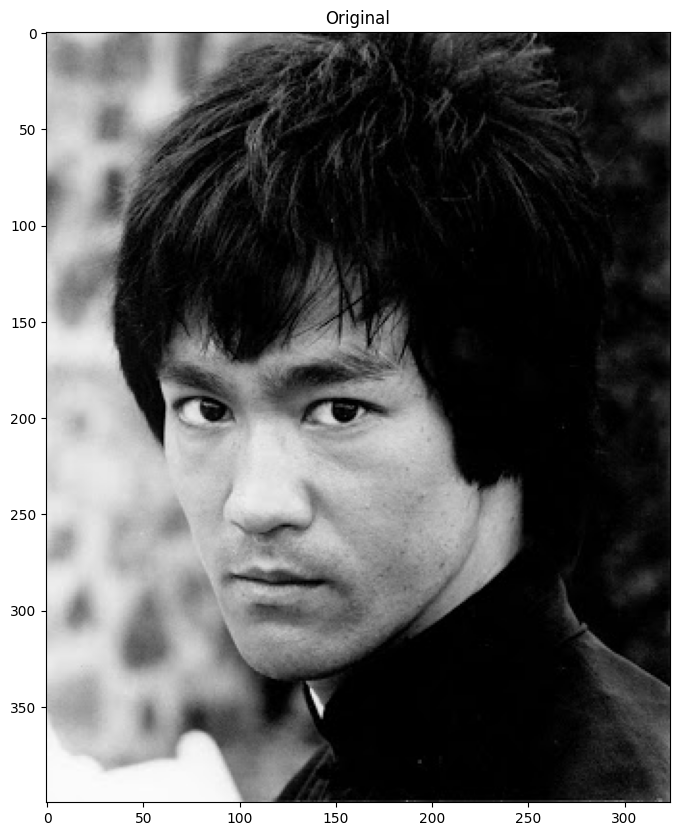

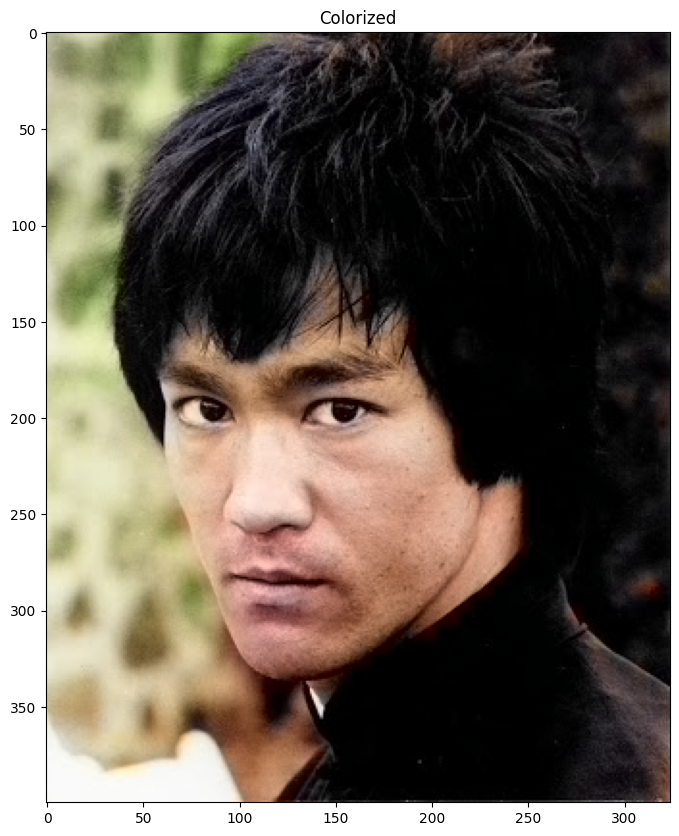

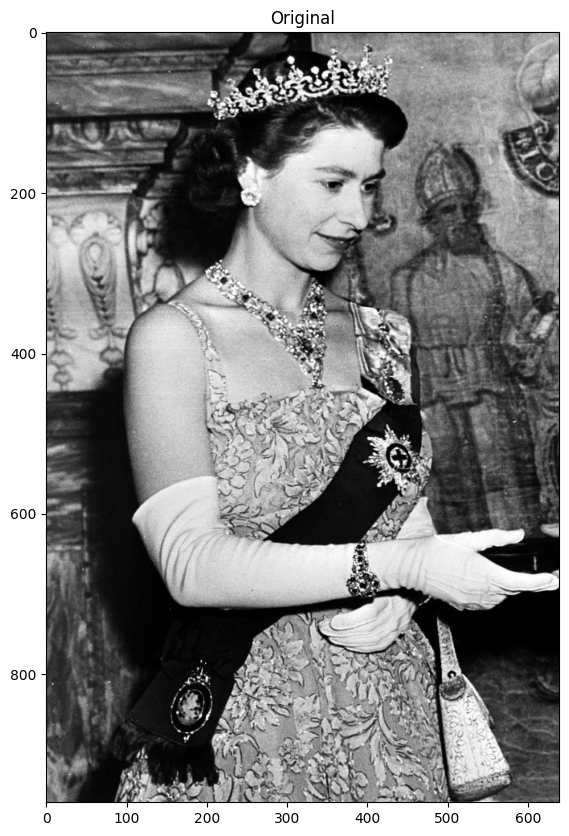

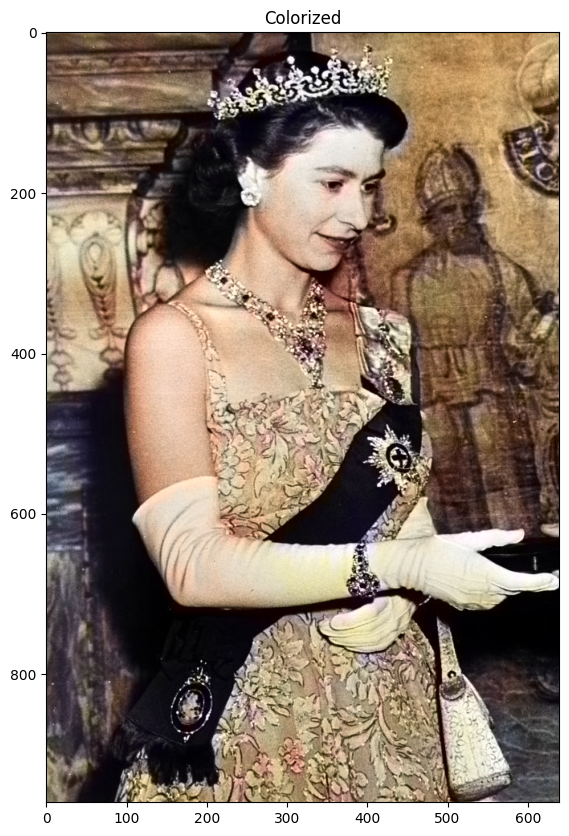

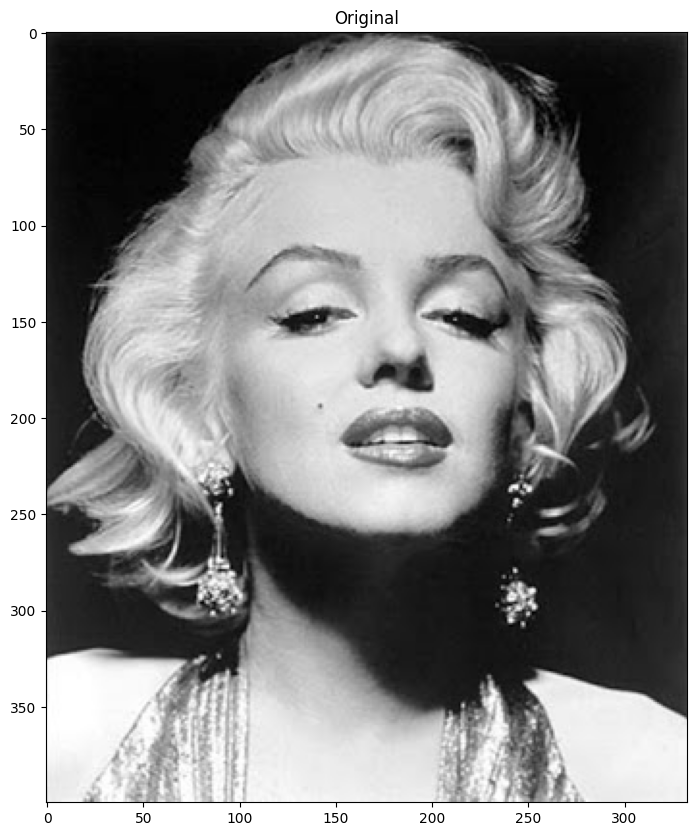

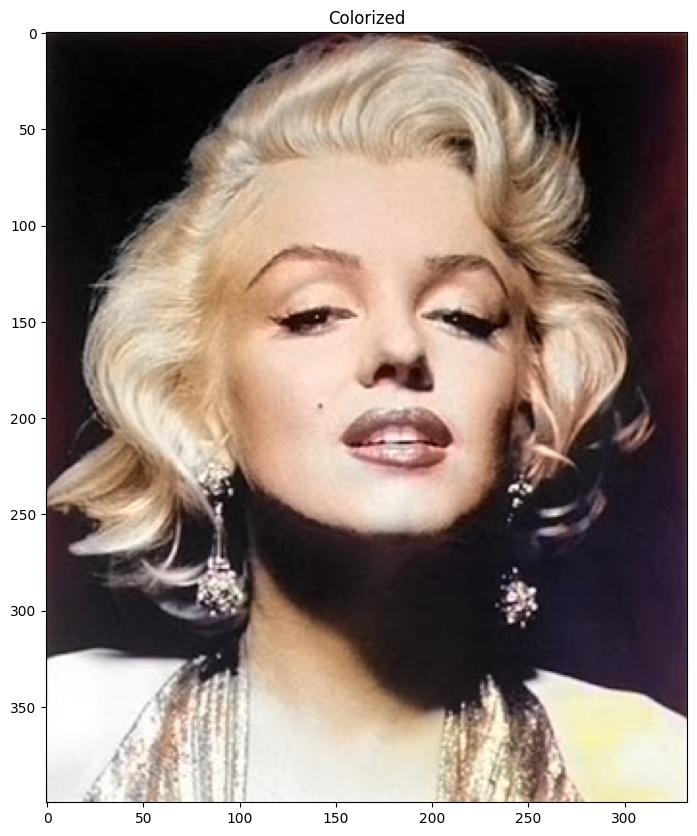

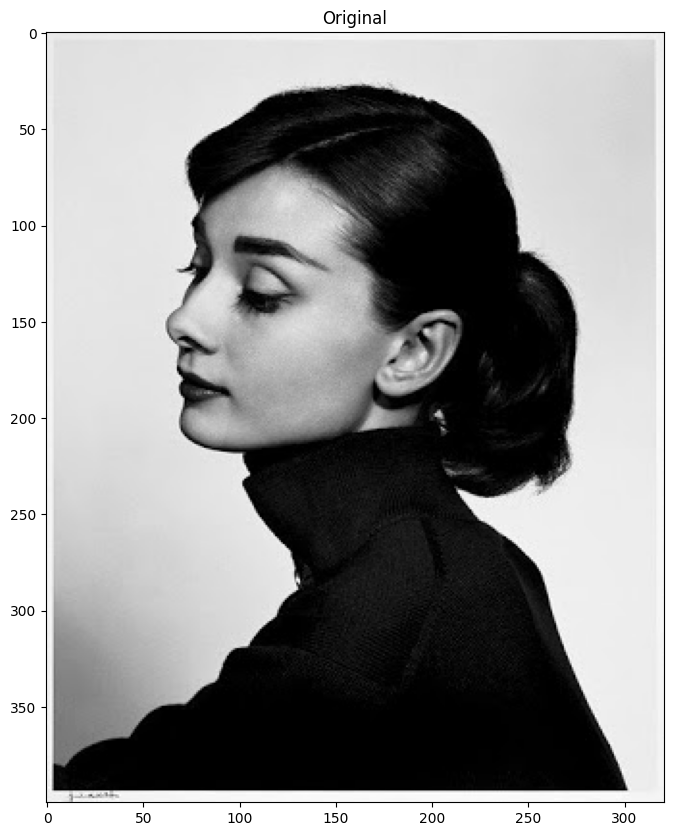

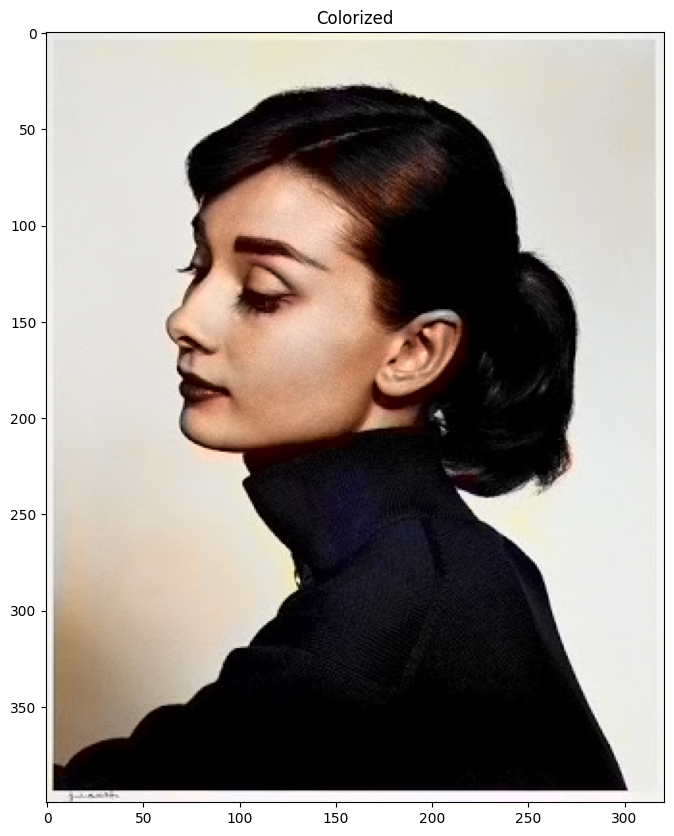

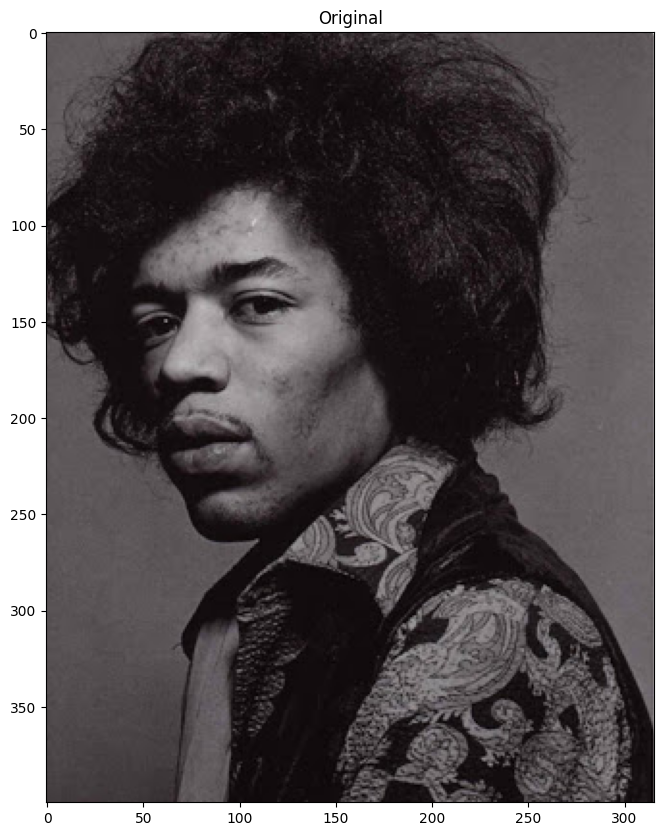

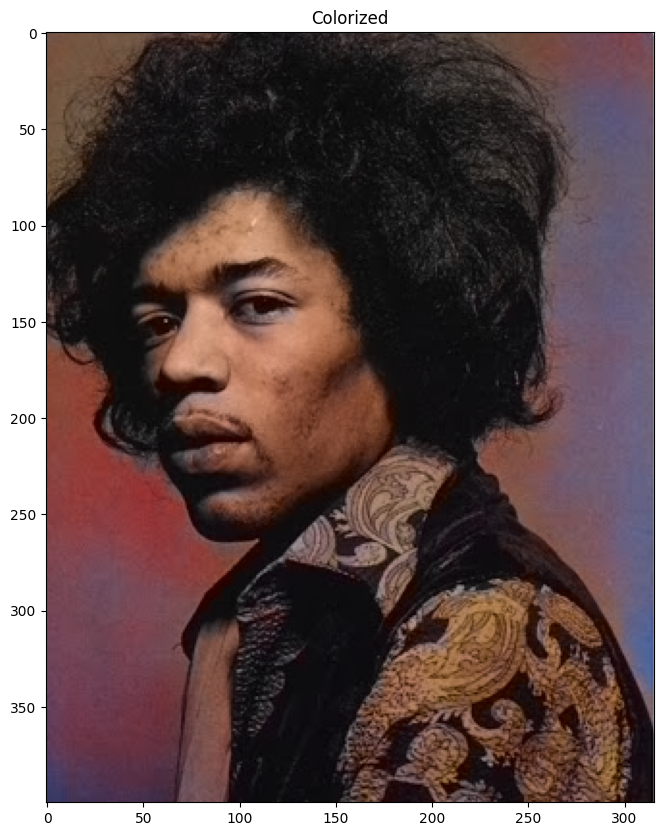

In [4]:
# Get our images
file_path = "../colorize/blackandwhite/"
blackandwhite_imgs = [f for f in listdir(file_path) if isfile(join(file_path, f))]
kernel = '../colorize/pts_in_hull.npy'

# Start the main program
if __name__ == "__main__":

    # Select desired model
    net = cv2.dnn.readNetFromCaffe("../colorize/colorization_deploy_v2.prototxt",
                                   "../colorize/colorization_release_v2.caffemodel")
    
    # load cluster centers
    pts_in_hull = np.load(kernel)

    # populate cluster centers as 1x1 convolution kernel
    pts_in_hulls = pts_in_hull.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hulls.astype(np.float32)]
    net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

    for image in blackandwhite_imgs:
        img = cv2.imread(file_path+image)

        img_rgb = (img[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)

        # pull out L channel
        img_l = img_lab[:,:,0]

        # get original image size
        (H_orig, W_orig) = img_rgb.shape[:2]

        # resize image to network input size
        img_rs = cv2.resize(img_rgb, (224, 224))

        # resize image to network input size
        img_lab_rs = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
        img_l_rs = img_lab_rs[:,:,0]

        # subtract 50 from mean-clustering
        img_l_rs -= 50

        net.setInput(cv2.dnn.blobFromImage(img_l_rs))

        # this is our result
        ab_dec = net.forward('class8_ab')[0,:,:,:].transpose((1,2,0))

        (H_out, W_out) = ab_dec.shape[:2]
        ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
        img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us), axis=2)

        # concatenate with original image L
        img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR), 0, 1)

        # show original image
        imshow('Original', img)
        # Resize the colorized image to it's original dimensions
        img_bgr_out = cv2.resize(img_bgr_out, (W_orig, H_orig), interpolation = cv2.INTER_AREA)
        imshow('Colorized', img_bgr_out)